<h1>Differentiating Through Theseus Layers</h1>

This tutorial shows how we can differentiate through Theseus layers to solve a collection of related least-squares optimization problems. 

The optimization problems of Tutorial 1 are done with one application (each) of the Theseus non-linear least squares optimizers, as they are straightforward curve-fitting problems. Theseus can also be used to solve more complex optimization problems, e.g., with dependencies between the quantities being optimized. In this tutorial, we will solve a set of curve-fitting problems that share one common parameter. As in Tutorial 1, we choose quadratic functions for simplicity: we wish to fit <i>y = ax<sup>2</sup> + b</i>, where <i>a</i> is fixed for all problems, and <i>b</i> is different for each problem. 

At a high-level, we solve this problem by using torch automatic differentiation to optimize the value of <i>a</i>, and optimize <i>b</i> for a given <i>a</i> with the non-linear least squares optimizers in Theseus. The rest of this notebook works through the necessary steps in detail. 

<h2>Step 0: Data Generation</h2> 

As before, we first generate data by sampling points from a set of quadratic functions <i>3x<sup>2</sup> + b</i>, where <i>b = 3, 5, ..., 21</i>. To this, we add Gaussian noise with <i>&sigma; = 0.01</i>.

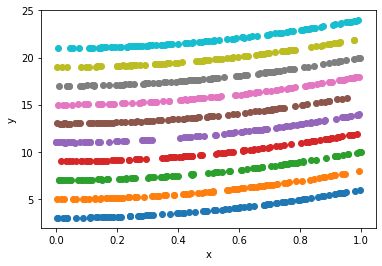

In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((1, num_points))
    noise = torch.randn((1, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

def generate_learning_data(num_points, num_models):
    a, b = 3, 1
    data_batches = []
    for i in range(num_models):
        b = b + 2
        data = generate_data(num_points, a, b)
        data_batches.append(data)
    return data_batches

num_models = 10
data_batches = generate_learning_data(100, num_models)

fig, ax = plt.subplots()
for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])
ax.set_xlabel('x');
ax.set_ylabel('y');

<h2>Step 1: Set up Theseus Optimization</h2>

Next, we set up the Theseus optimization problem similar to Tutorial 1, but with one key change: <i>a</i> is no longer an optimization variable for the Theseus NLLS optimizer; instead, it is an auxiliary variable whose value will be optimized by PyTorch through backpropagation. <i>b</i> remains the only optimization variable for the Theseus NLLS optimizer. The code below illustrates this.

In [2]:
import theseus as th

data_x, data_y = data_batches[0]
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

# Note 'b' is the only optim_var, and 'a' is part of aux_vars
optim_vars = [b]
aux_vars = a, x, y

# updated error function reflects change in 'a'
def quad_error_fn2(optim_vars, aux_vars):
    [b] = optim_vars 
    a, x, y = aux_vars
    est = a.data * x.data.square() + b.data
    err = y.data - est
    return err

cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn2, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)
optimizer = th.GaussNewton(
    objective,
    max_iterations=50,
    step_size=0.5,
)
theseus_optim = th.TheseusLayer(optimizer)

# The value for Variable 'a' is optimized by PyTorch backpropagation
a_tensor = torch.nn.Parameter(torch.rand(1, 1))
model_optimizer = torch.optim.Adam([a_tensor], lr=0.1)

<h2>Step 2: Run Optimization and Learning</h2> 

Finally, we compute <i>a</i> and <i>b</i> by using a learning loop around the Theseus NLLS optimizer, with each model's data taken as a single batch. The Theseus NLLS optimizer optimizes `b` for the current `a` (referred to as the <i>inner loop optimization</i>), while the PyTorch backpropagation learns the correct value to use for `a` across the batches (referred to as the <i>outer loop optimization</i>). 

For clarity, we describe the high-level steps required:
- Step 2.1: As in Tutorial 1, we begin by creating a dictionary of inputs, and pass it to the `forward` function of the `TheseusLayer`. Note that the `forward` function here does not track the best solution in this example, as the entire NLLS optimization sequence needs to be used for backpropagation. 
After the optimization completes in the `TheseusLayer`, we get a dictionary `updated_inputs` with latest values of the optimization variables (and all other dictionary values unchanged). 
- Step 2.2: We then update the `objective` with the `updated_inputs` dictionary, and use it to compute the loss. This kind of use of the Theseus optimization variables is the reason the `forward` returns a dictionary of inputs.
- Step 2.3: This loss is used for backpropagation. The PyTorch learning optimizer (i.e. Adam here) will now take one optimization step for the learning parameters (i.e., `a`'s value in this example).
- Iterate: We now make a new call to `forward`, repeating Steps 2.1-2.3. 

We illustrate these steps in the code below.

In [3]:
num_batches = len(data_batches)
num_epochs = 20

print(f"Initial a value: {a_tensor.item()}")

for epoch in range(num_epochs):
    epoch_loss = 0.
    epoch_b = []  # keep track of the current b values for each model in this epoch
    for i in range(num_batches):
        model_optimizer.zero_grad()
        data_x, data_y = data_batches[i]
        # Step 2.1: Create input dictionary for TheseusLayer, pass to forward function
        # The value for variable `a` is the updated `a_tensor` by Adam
        # Since we are always passing the same tensor, this update is technically redundant, 
        # we include it to explicitly illustrate where variable values come from.
        # An alternative way to do this (try it!)
        # would be to call `a.update(a_tensor)` before the learning loop starts
        # and just let Adam change its value under the hood (i.e., update only `x`, `y`, and `b`
        # inside the loop)
        theseus_inputs = {
            "a": a_tensor,
            "x": data_x,
            "y": data_y,
            "b": torch.ones((1, 1)),
        }
        updated_inputs, info = theseus_optim.forward(theseus_inputs)
        epoch_b.append(updated_inputs["b"].item())  # add the optimized "b" of the current batch to `epoch_b` list. 
                                                    # Note: here, we do not track the best solution, as we 
                                                    # backpropagate through the entire optimization sequence.
        # Step 2.2: Update objective function with updated inputs
        objective.update(updated_inputs)
        loss = cost_function.error().square().mean()
        # Step 2.3: PyTorch backpropagation
        loss.backward()
        model_optimizer.step()

        loss_value = loss.item()
        epoch_loss += loss_value
    print(f"Epoch: {epoch} Loss: {epoch_loss}")
    if epoch % 5 == 4:
        print(f" ---------------- Solutions at Epoch {epoch:02d} -------------- ")
        print(" a value:", a.data.item())
        print(" b values: ", epoch_b)
        print(f" ----------------------------------------------------- ")

Initial a value: 0.8671661019325256
Epoch: 0 Loss: 2.550027549266815
Epoch: 1 Loss: 0.5708533525466919
Epoch: 2 Loss: 0.0265085999853909
Epoch: 3 Loss: 0.04149620106909424
Epoch: 4 Loss: 0.03596132283564657
 ---------------- Solutions at Epoch 04 -------------- 
 a value: 3.1208860874176025
 b values:  [2.9216177463531494, 4.930838584899902, 6.922538757324219, 8.923272132873535, 10.926830291748047, 12.952813148498535, 14.932782173156738, 16.949243545532227, 18.946279525756836, 20.954736709594727]
 ----------------------------------------------------- 
Epoch: 5 Loss: 0.005245754415227566
Epoch: 6 Loss: 0.002350384122109972
Epoch: 7 Loss: 0.0025651332980487496
Epoch: 8 Loss: 0.0010936586622847244
Epoch: 9 Loss: 0.001083762341295369
 ---------------- Solutions at Epoch 09 -------------- 
 a value: 3.01115083694458
 b values:  [2.99800181388855, 4.999911308288574, 6.998246669769287, 8.995952606201172, 10.996501922607422, 12.998129844665527, 14.996124267578125, 16.99513053894043, 18.9946346

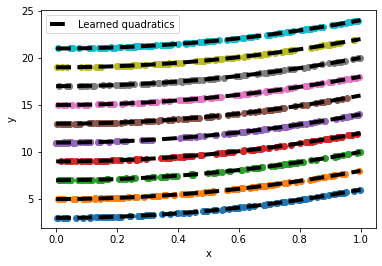

In [4]:
# Plot the learned functions
fig, ax = plt.subplots()

for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])

    a = a.data.squeeze().detach()
    b = epoch_b[i]
    x = torch.linspace(0., 1., steps=100)
    y = a*x*x + b
    ax.plot(x, y, color='k', lw=4, linestyle='--',
            label='Learned quadratics' if i == 0 else None)
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');

We observe that we are able to recover `a` and `b` very close to the values we sampled from. 

<h2>Step 3 (Optional): Solving all Optimization Problems Simultaneously</h2>

The above is only one of many ways to model our problem with Theseus. Theseus also supports solving multiple optimization problems simultaneously, so we could also solve all of the 10 least-squares optimization problems simultaneously. We can do this in two natural ways:
- Version A: by creating 10 `AutoDiffCostFunction`s, one for each optimization problem. Here, we need each `AutoDiffCostFunction` to have a separate `b, x, y` variables (e.g., `[b1, x1, y1]`, `[b2, x2, y2]` etc). All cost functions are added to the objective, and they can be optimized jointly with one `forward`, and differentiated through jointly with the following `backward`. 
- Version B: by changing the `b, x, y` variables to be batched, and having the error function above `quad_err_fn2` to support batches, we can use a single `AutoDiffCostFunction` to capture the cost of their fit. However, because the error may now be batched, the loss has to be computed as an aggregate of the evaluated objective. 

Version A is more commonly used in situations where each variable and cost-function has a different sematic interpretation (e.g., different time-steps in the motion-planning problem of Tutorial 4 & 5), while Version B is commonly used for multiple instances of the same problem (e.g., different maps in Tutorials 4 & 5). We show below the complete code for each version. Both versions find very similar `a` and `b` values. 

Because both versions need a common learning routine, we first create a subroutine `optimize_and_learn_models_jointly` for readability. 

In [5]:
# Sub-routine to optimize and learn models simultaneously

def optimize_and_learn_models_jointly(theseus_optim, model_optimizer, num_epochs=20):
    # again, assume a_tensor is initialized outside this loop
    print(f"Initial a value: {a_tensor.item()}")
    
    for epoch in range(num_epochs):
        model_optimizer.zero_grad()
        # Step 2.1: Create input dictionary for TheseusLayer, pass to forward function
        theseus_inputs = construct_theseus_layer_inputs()
        updated_inputs, _ = theseus_optim.forward(theseus_inputs)

        # Step 2.2: Update objective function with updated inputs
        objective.update(updated_inputs)
        loss = objective.error_squared_norm() 
        loss = loss.sum()  # Note `loss` now needs a final aggregation (for version B)

        # Step 2.3: PyTorch backpropagation
        loss.backward()
        model_optimizer.step()

        if epoch == 0:
            min_loss = loss
        if loss <= min_loss:
            min_loss = loss
            best_model_a = a.data.item()
            best_model_b = [b.data.item() for b in all_b]

        print(f"Epoch: {epoch} Loss: {loss.item()}")
        if epoch % 10 == 9:
            print(f" ---------------- Solutions at Epoch {epoch:02d} -------------- ")
            print(" a value:", a.data.item())
            print(" b values: ", [b.data.item() for b in all_b])
            print(f" ----------------------------------------------------- ")

    return best_model_a, best_model_b

<h3>Step 3.1: Example Version A</h3>

Now we show Version A. This version makes the following changes from the original code snippet:
- create 10 `x`, `y` and `b` variables.
- create 10 `AutoDiffCostFunctions`, each using the same `a` but the corresponding `b_i`, `x_i` and `y_i`. All cost functions are added to the objective.
- construct the `theseus_inputs` dictionary with the `b_i`, `x_i` and `y_i` mapped to the correct data batch.

Note that `a` and its setup the PyTorch optimizer remain the same. Once the optimization problem is setup, we call `optimize_and_learn_models_jointly` sub-routine to compute the `a` and `b` values. 

In [ ]:
# Version A

# replace x and y with 10 different variables x0 ... x9, y0 ... y9
all_x, all_y = [], []
for i in range(num_models): 
    all_x.append(th.Variable(data_x, name=f"x{i}"))
    all_y.append(th.Variable(data_y, name=f"y{i}"))

# replace b with 10 different variables b0 ... b9
all_b = []
for i in range(num_models):
    all_b.append(th.Vector(1, name=f"b{i}"))

# a remains the same
a = th.Vector(1, name="a")

# objective now has 10 different cost functions
objective = th.Objective()
for i in range(num_models):
    # each cost function i uses b_i as optim_var and x_i, y_i and a as aux_var
    optim_vars = [all_b[i]]
    aux_vars = a, all_x[i], all_y[i]
    cost_function = th.AutoDiffCostFunction(
        optim_vars, quad_error_fn2, 100, aux_vars=aux_vars, name=f"quadratic_cost_fn_{i}"
    )
    objective.add(cost_function)

# optimizer, TheseusLayer and model optimizer remains the same
optimizer = th.GaussNewton(
    objective, max_iterations=50, step_size=0.4,
)
theseus_optim = th.TheseusLayer(optimizer)
a_tensor = torch.nn.Parameter(torch.rand(1, 1))
model_optimizer = torch.optim.Adam([a_tensor], lr=0.15)

# TheseusLayer dictionary now needs to construct b0 ... b9, x0 ... x9, y0 ... y9
def construct_theseus_layer_inputs():
    theseus_inputs = {}
    for i in range(num_models):
        data_x, data_y = data_batches[i]
        theseus_inputs.update({
            f"x{i}": data_x,
            f"y{i}": data_y,
            f"b{i}": torch.ones((1, 1)),
        })
    theseus_inputs.update({"a": a_tensor})
    return theseus_inputs

# Run Theseus optimization and learning
best_model = optimize_and_learn_models_jointly(theseus_optim, model_optimizer)

print(f" ---------------- Final Solutions -------------- ")
print(" a value:", best_model[0])
print(" b values: ", best_model[1])
print(f" ----------------------------------------------- ")


Initial a value: 0.4854246973991394
Epoch: 0 Loss: 548.7742919921875
Epoch: 1 Loss: 485.24896240234375
Epoch: 2 Loss: 425.75042724609375
Epoch: 3 Loss: 370.3395690917969
Epoch: 4 Loss: 319.0608215332031
Epoch: 5 Loss: 271.9399108886719
Epoch: 6 Loss: 228.9813232421875


In [ ]:
# Plot the learned functions
fig, ax = plt.subplots()

for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])

    a = best_model[0]
    b = best_model[1][i]
    x = torch.linspace(0., 1., steps=100)
    y = a*x*x + b
    ax.plot(x, y, color='k', lw=4, linestyle='--',
            label='Learned quadratics' if i == 0 else None)
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');

<h3>Step 3.2: Example Version B</h3>

Now we show Version B. This version makes the following changes from the original code snippet:
- create `x`, `y` variables of sizes `[num_models, 100]` instead of `[1, 100]`
- create `b` variable of size `[num_models, 1]` instead of `[1, 1]`
- construct the `theseus_inputs` dictionary with `b`, `x` and `y` data batched

In this example, we do not need to change the error function, because PyTorch tensors handle the broadcasting for the batched version to work. 

As before, `a` and its setup for the PyTorch optimizer remain the same. Once the optimization problem is setup, we call `optimize_and_learn_models_jointly` sub-routine to solve the problem.

In [ ]:
# Version B

# convert data_x, data_y into torch.tensors of shape [num_models, 100]
data_x = torch.stack([data_x.squeeze() for data_x, _ in data_batches])
data_y = torch.stack([data_y.squeeze() for _, data_y in data_batches])

# construct one variable each of x, y of shape [num_models, 100]
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")

# construct a as before
a = th.Vector(1, name="a")

# construct one variable b, now of shape [num_models, 1]
b = th.Vector(data=torch.rand(num_models, 1), name="b")

# Again, 'b' is the only optim_var, and 'a' is part of aux_vars along with x, y
optim_vars = [b]
aux_vars = a, x, y

# cost function constructed as before 
cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn2, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)

# objective, optimizer and theseus layer constructed as before
objective = th.Objective()
objective.add(cost_function)
optimizer = th.GaussNewton(
    objective, max_iterations=50, step_size=0.5,
)
theseus_optim = th.TheseusLayer(optimizer)

# As before, 'a' is optimized by PyTorch backpropagation
# model_optimizer constructed the same way 
a_tensor = torch.nn.Parameter(torch.rand(1, 1))
model_optimizer = torch.optim.Adam([a_tensor], lr=0.2)

# The theseus_inputs dictionary is also constructed similarly to before,
# but with data matching the new shapes of the variables
def construct_theseus_layer_inputs():
    theseus_inputs = {}
    theseus_inputs.update({
        "x": data_x,
        "y": data_y,
        "b": torch.ones((num_models, 1)),
        "a": a_tensor,
    })
    return theseus_inputs

# Run Theseus optimization and learning
best_model = optimize_and_learn_models_jointly(theseus_optim, model_optimizer)
print(f" ---------------- Final Solutions -------------- ")
print(" a value:", best_model[0])
print(" b values: ", best_model[1])
print(f" ----------------------------------------------- ")

In [ ]:
# Plot the learned functions
fig, ax = plt.subplots()

for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])

    a = best_model[0]
    b = best_model[1][i]
    x = torch.linspace(0., 1., steps=100)
    y = a*x*x + b
    ax.plot(x, y, color='k', lw=4, linestyle='--',
            label='Learned quadratics' if i == 0 else None)
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');

Technical note: You may note that in this example, the differentiation occurs only through the TheseusLayer objective, not through the Theseus non-linear least squares optimizers. This is due to the simplicity of the example problem. A more complex series of inner loop computations will require Theseus to also differentiate through the non-linear least squares optimizers; such problems are in Tutorials 4 & 5, as well as in the [Theseus `examples` folder](https://github.com/facebookresearch/theseus/tree/main/examples).